EXPLANATION OF OUTPUT VARIABLES (the relevant trials are the "canvas-keyboard-response" ones):

Experiment flow:
- *block_index* -> index of the block (NB: starts from zero)
- *presentation_index* -> index of the presentation inside one block (NB: starts from zero)

Experiment parameters:
- *clique_size* -> size of the clique in one of the two displayed graphs
- *graphs_size* -> size of the displayed graphs 
- *graphs_couple* -> couple of graphs shown in current trial
- *nodes_order* -> order of the nodes in current trial

Dependent variables:
- *rt* -> response time in ms (collected automatically)
- *response* -> in this experiment, the accepted keys are " "; "arrowright" or "arrowleft"
- *accuracy* -> this variable is manually computed and added only to the trials where response was arrowright or arrowleft

Comparison variables:
- *correct_response* -> correct response for current trial

Produced automatically / not relevant:

For all trials:
- *trial_type* -> the name of the plugin used to run the trial (the real trials of the experiment are "canvas-keyboard-response")
- *trial_index* -> the index of the current trial across the whole experiment (it is a global counter of trials, it also includes instructions and tutorial ones)
- *time_elapsed* -> the number of milliseconds between the start of the experiment and when the trial ended
- *internal_node_id* -> string identifier for the current TimelineNode

For preload plugin:
- *success*	-> if true, then all files loaded successfully within the max_load_time. If false, then one or more file requests returned a failure and/or the file loading did not complete within the max_load_time duration.
- *timeout* -> 	if true, then the files did not finish loading within the max_load_time duration. If false, then the file loading did not timeout.
- *failed_images* -> one or more image file paths that produced a loading failure before the trial ended.
- *failed_audio* -> one or more audio file paths that produced a loading failure before the trial ended.
- *failed_video* -> one or more video file paths that produced a loading failure before the trial ended.

For instructions plugin:
- *rt* -> the response time (in ms) for the subject to view all of the pages
- *view_history* -> array containing the order of pages the subject viewed (collected only for "instructions" plugin)

For image-keyboard-response plugin:
- *stimulus* -> the path of the image that was displayed.



------------------------------------------------------------------------------------------------------------

Importing packages:

In [5]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from pathlib import Path

# for swarmplot
import seaborn as sns

# # to correctly sort file names (maintaining correspondence with subject numbers):
# from natsort import os_sorted

Importing and "cleaning" a single experiment csv file:

In [9]:
file1Path = Path('./mock_data/HUPLACLIP_pilot_SESSION_2023-05-16_14h17.36.418.csv')
df1 = pd.read_csv(file1Path)
# isolating experiment trials ("canvas-keyboard-response" ones)
df1_experiment = df1[df1.trial_type == "canvas-keyboard-response"]
# dropping empty/irrelevant variables:
df1_cleaned = df1_experiment.drop(["view_history","trial_index", "time_elapsed","internal_node_id" ,"success", "timeout", "failed_images", "failed_audio", "failed_video", "stimulus"], axis=1)
# isolating trials were final responses were given (shuffles have " " as response):
df1_cleaned_final_answers = df1_cleaned[df1_cleaned['response'].isin(['arrowright','arrowleft'])]
print(df1_cleaned_final_answers.shape)     #final responses should be 120 (30 for each one of the 4 blocks)
# counting the final answers for each clique size
df1_cleaned_final_answers['clique_size'].value_counts()  #the clique sizes should be 15, and there should be 8 trials for each clique size


(180, 12)


175.0    12
163.0    12
152.0    12
140.0    12
128.0    12
117.0    12
105.0    12
93.0     12
82.0     12
70.0     12
58.0     12
47.0     12
35.0     12
23.0     12
12.0     12
Name: clique_size, dtype: int64

clique size:
12.0
fraction correct:
0.4166666666666667
--------------------------
clique size:
23.0
fraction correct:
0.3333333333333333
--------------------------
clique size:
35.0
fraction correct:
0.5833333333333334
--------------------------
clique size:
47.0
fraction correct:
0.5
--------------------------
clique size:
58.0
fraction correct:
0.6666666666666666
--------------------------
clique size:
70.0
fraction correct:
0.5833333333333334
--------------------------
clique size:
82.0
fraction correct:
0.5833333333333334
--------------------------
clique size:
93.0
fraction correct:
0.75
--------------------------
clique size:
105.0
fraction correct:
0.25
--------------------------
clique size:
117.0
fraction correct:
0.6666666666666666
--------------------------
clique size:
128.0
fraction correct:
0.5
--------------------------
clique size:
140.0
fraction correct:
0.6666666666666666
--------------------------
clique size:
152.0
fraction correct:
0.5
--------------------------
cl

Text(0.5, 1.0, 'sample size = 1')

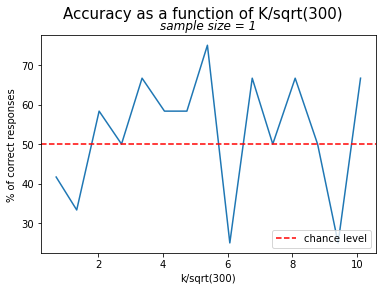

In [8]:
# plotting fraction correct as a function of "clique_size"
# - calculating accuracy for the different levels of "clique_size"
fraction_correct_dict = dict()
# reversing the order of clique_size array:
reversed_clique_size_array = df1_cleaned_final_answers.clique_size.unique()[::-1]
for i in reversed_clique_size_array:
    # isolating data of current clique size:
    current_data = df1_cleaned_final_answers[df1_cleaned_final_answers.clique_size == i]
    # calculating fraction correct for current clique size
    fraction_correct_current_clique_size = sum(current_data.accuracy == True) / sum(~ current_data.accuracy.isna())
    # adding to the dictionary
    fraction_correct_dict[str(round(i))] = fraction_correct_current_clique_size
    
    #CONTROL:
    print("clique size:")
    print(i)
    print("fraction correct:")
    print(fraction_correct_current_clique_size)
    print("--------------------------")
    
# plotting the results:
# - obtaining appropriate x and y values:
x_values = list(fraction_correct_dict.keys())
x_values = [int(x_value)/(math.sqrt(300))  for x_value in x_values]
y_values = list(fraction_correct_dict.values())
y_values = [y_value * 100 for y_value in y_values]
# - drawing plot:
plt.plot(x_values,y_values)
plt.xlabel("k/sqrt(300)")
plt.ylabel("% of correct responses")
# plotting chance level line and adding legend
plt.axhline(y = 50, color = 'r', linestyle = 'dashed', label = "chance level")
plt.legend(loc = 'lower right')
plt.suptitle("Accuracy as a function of K/sqrt(300)", fontsize = 15)
plt.title("sample size = 1", fontstyle= "italic")

Importing multiple csv files, combining them in a single dataframe and removing irrelvant variables:

In [10]:
# creating empty dataframe:
data = pd.DataFrame()
# accessing all json files in 'data' directory:
files = Path('./mock_data/').glob('*.csv')
fileCounter = 0
for file in files:
    # reading single csv file as dataframe
    df = pd.read_csv(file)
    # adding single dataframe to general dataframe:
    data = pd.concat([data,df])
    # incrementing file counter (will be used to label the graph):
    fileCounter += 1

# isolating experiment trials ("canvas-keyboard-response" ones)
data_experiment = data[data.trial_type == "canvas-keyboard-response"]

# dropping irrelevant variables:
data_experiment.drop(["view_history","trial_index", "time_elapsed","internal_node_id" ,"success", "timeout", "failed_images", "failed_audio", "failed_video", "stimulus"], axis=1, inplace=True)

# checking that cleaning happened successfully:
print(data_experiment.columns.tolist())
print(data_experiment.shape)

# isolating trials were final responses were given (shuffles have " " as response):
data_experiment_final = data_experiment[data_experiment['response'].isin(['arrowright','arrowleft'])]
print(data_experiment_final.shape)     # final responses = 12*(number of csv files in data folder)
# counting the final answers for each clique size
print(data_experiment_final['clique_size'].value_counts()  )

['trial_type', 'rt', 'response', 'nodes_order', 'correct_response', 'block_index', 'presentation_index', 'clique_size', 'graph_size', 'graphs_names', 'graphs_couple', 'accuracy']
(373, 12)
(360, 12)
175.0    24
163.0    24
152.0    24
140.0    24
128.0    24
117.0    24
105.0    24
93.0     24
82.0     24
70.0     24
58.0     24
47.0     24
35.0     24
23.0     24
12.0     24
Name: clique_size, dtype: int64


d:\akenjeev\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[50.0, 41.66666666666667, 50.0, 50.0, 58.333333333333336, 41.66666666666667, 70.83333333333334, 62.5, 37.5, 70.83333333333334, 45.83333333333333, 50.0, 58.333333333333336, 37.5, 62.5]


Text(0.5, 1.0, 'sample size = 2')

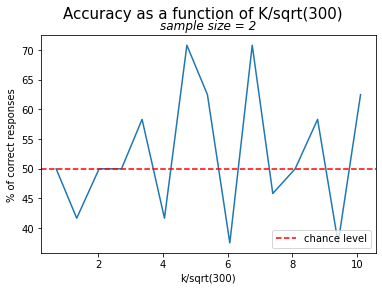

In [11]:
# plotting fraction correct as a function of "clique_size"
# - calculating accuracy for the different levels of "clique_size"
fraction_correct_dict = dict()
# reversing the order of clique_size array:
reversed_clique_size_array = df1_cleaned_final_answers.clique_size.unique()[::-1]
for i in reversed_clique_size_array:
    # isolating data of current clique size:
    current_data = data_experiment_final[data_experiment_final.clique_size == i]
    # calculating fraction correct for current clique size
    fraction_correct_current_clique_size = sum(current_data.accuracy == True) / sum(~ current_data.accuracy.isna())
    # adding to the dictionary
    fraction_correct_dict[str(round(i))] = fraction_correct_current_clique_size
    
    # # DEBUG:
    # print("clique size:")
    # print(i)
    # print("fraction correct:")
    # print(fraction_correct_current_clique_size)
    # print(current_data.accuracy)
    
# plotting the results:
# - obtaining appropriate x and y values:
x_values = list(fraction_correct_dict.keys())
x_values = [int(x_value)/(math.sqrt(300))  for x_value in x_values]
y_values = list(fraction_correct_dict.values())
y_values = [y_value * 100 for y_value in y_values]
print(y_values)
# - drawing plot:
plt.plot(x_values,y_values)
plt.xlabel("k/sqrt(300)")
plt.ylabel("% of correct responses")
# plotting chance level line and adding legend
plt.axhline(y = 50, color = 'r', linestyle = 'dashed', label = "chance level")
plt.legend(loc = 'lower right')
plt.suptitle("Accuracy as a function of K/sqrt(300)", fontsize = 15)
plt.title('sample size = {}'.format(fileCounter), fontstyle= "italic")

Separately calculating accuracy of the different subjects for the various levels of clique size:

In [12]:
# creating empty dataframe:
data = pd.DataFrame()
# accessing all json files in 'data' directory:
files = Path('./mock_data/').glob('*.csv')
# # reordering paths so that correspondence with subject number is maintained (otherwise subject 10 data is read first):
# files = os_sorted(files)  NOT NEEDED BECAUSE NOW 01-02-03...
# reversing the order of clique_size array (in experiment is 175 -> 0, in graph is 0 -> 175):
reversed_clique_size_array = df1_cleaned_final_answers.clique_size.unique()[::-1]
# subject counter (will be used to label the keys of the plot dictionary):
subject_counter = 1
# plot dataframe (rows = subjects ; columns = array of clique sizes. Each line contains the accuracy of that subject for all the clique sizes )
plot_dict = dict()
for file in files:
    
    # # DEBUG:
    print(file)
    
    # reading single csv file as dataframe
    df = pd.read_csv(file)
    # isolating experiment trials:
    df_experiment = df[df.trial_type == "canvas-keyboard-response"]
    # dropping irrelevant variables:
    df_experiment_cleaned = df_experiment.drop(["view_history","trial_index", "time_elapsed","internal_node_id" ,"success", "timeout", "failed_images", "failed_audio", "failed_video", "stimulus"], axis=1)
    # isolating trials of final responses:
    df_experiment_final = df_experiment_cleaned[df_experiment_cleaned['response'].isin(['arrowright','arrowleft'])]
    # creating empty array of accuracies:
    accuracies_for_subject = []
    for i in reversed_clique_size_array:
        # isolating data of current clique size:
        current_data = df_experiment_final[df_experiment_final.clique_size == i]
        # calculating fraction correct for current clique size and transforming it in percentage 
        fraction_correct_current_clique_size = ( sum(current_data.accuracy == True) / sum(~ current_data.accuracy.isna()) )*100
        # appending single accuracy to the array of accuracies:
        accuracies_for_subject.append(fraction_correct_current_clique_size)  
    # adding accuracy array to the dictionary
    plot_dict[subject_counter] = accuracies_for_subject
    # increasing subject counter:
    subject_counter += 1

mock_data\HUPLACLIP_pilot_SESSION_2023-05-16_14h17.36.418.csv
mock_data\HUPLACLIP_pilot_SESSION_2023-05-16_14h59.23.769.csv


In [13]:
print(plot_dict)
# printing separately the accuracies to check their correctness
accuracies_per_subjects = list(plot_dict.values())
accuracies_per_subjects = [print(subject_accuracies) for subject_accuracies in accuracies_per_subjects]

{1: [41.66666666666667, 33.33333333333333, 58.333333333333336, 50.0, 66.66666666666666, 58.333333333333336, 58.333333333333336, 75.0, 25.0, 66.66666666666666, 50.0, 66.66666666666666, 50.0, 25.0, 66.66666666666666], 2: [58.333333333333336, 50.0, 41.66666666666667, 50.0, 50.0, 25.0, 83.33333333333334, 50.0, 50.0, 75.0, 41.66666666666667, 33.33333333333333, 66.66666666666666, 50.0, 58.333333333333336]}
[41.66666666666667, 33.33333333333333, 58.333333333333336, 50.0, 66.66666666666666, 58.333333333333336, 58.333333333333336, 75.0, 25.0, 66.66666666666666, 50.0, 66.66666666666666, 50.0, 25.0, 66.66666666666666]
[58.333333333333336, 50.0, 41.66666666666667, 50.0, 50.0, 25.0, 83.33333333333334, 50.0, 50.0, 75.0, 41.66666666666667, 33.33333333333333, 66.66666666666666, 50.0, 58.333333333333336]


In [ ]:
# creating dataframes of accuracies from dictionary (rows are subjects, columns are clique sizes):
plot_dataframe = pd.DataFrame.from_dict(plot_dict, orient='index',columns=x_values)
# printing dataframe:
print(plot_dataframe)

    0.692820   1.327906   2.020726   2.713546   3.348632   4.041452   \
1        62.5       50.0       37.5       87.5      100.0       87.5   
2        50.0       62.5       62.5       62.5       87.5      100.0   
3        25.0       62.5       50.0       87.5       62.5       87.5   
4        37.5       62.5       62.5       62.5      100.0      100.0   
5        75.0       25.0       75.0       62.5       87.5       87.5   
6        62.5       12.5       25.0       50.0       87.5      100.0   
7        50.0       50.0       62.5       62.5       75.0      100.0   
8        25.0       75.0       25.0       87.5       87.5      100.0   
9        75.0       62.5       50.0       50.0       50.0       75.0   
10       62.5       37.5       62.5       75.0       75.0      100.0   

    4.734272   5.369358   6.062178   6.754998   7.390083   8.082904   \
1       100.0      100.0      100.0      100.0      100.0      100.0   
2       100.0      100.0      100.0      100.0      100.0      

In [ ]:
# CREATING DATAFRAME THAT SUITS SWARMPLOT:
# - creating SUBJECT NUMBER column (1 (15 times), 2 (15 times)...):
subject_number_list = sorted(list(range(1,11))*15)

# - creating CLIQUE SIZE column (reversed_clique_size_array -> repeated 10 times)
clique_size_list = []
for i in range(10):
    clique_size_list.extend(reversed_clique_size_array)

# - creating X LABEL column (clique size transformed according to Rudy's graph):
x_label_list = [round(int(x_value)/(math.sqrt(300)),1)  for x_value in reversed_clique_size_array]*10

# - creating  SUBJECT ACCURACY column (long list of 150 values, 1:15 -> all mean accuracies for subj 1; 16:30 -> all mean accuracies for subj 2 ...)
subject_accuracy_list = []
for sublist in list(plot_dict.values()):
    for item in sublist:
        subject_accuracy_list.append(item)

# creating dictionary for swarmplot:
swarmplot_dict = { 'subject_number': subject_number_list, 'clique_size': clique_size_list, 'x_label': x_label_list, 'subject_accuracy': subject_accuracy_list}

# creating dataframe from dictionary:
swarmplot_df = pd.DataFrame.from_dict(swarmplot_dict)
print(swarmplot_df)

     subject_number  clique_size  x_label  subject_accuracy
0                 1         12.0      0.7              62.5
1                 1         23.0      1.3              50.0
2                 1         35.0      2.0              37.5
3                 1         47.0      2.7              87.5
4                 1         58.0      3.3             100.0
..              ...          ...      ...               ...
145              10        128.0      7.4             100.0
146              10        140.0      8.1             100.0
147              10        152.0      8.8             100.0
148              10        163.0      9.4             100.0
149              10        175.0     10.1             100.0

[150 rows x 4 columns]


In [ ]:
# calculate MEAN ACCURACY and put it in new dataframe:
mean_accuracy_df = swarmplot_df.groupby('x_label')["subject_accuracy"].mean().reset_index()
print(mean_accuracy_df)

    x_label  subject_accuracy
0       0.7             52.50
1       1.3             50.00
2       2.0             51.25
3       2.7             68.75
4       3.3             81.25
5       4.0             93.75
6       4.7             97.50
7       5.4            100.00
8       6.1             98.75
9       6.8             97.50
10      7.4             98.75
11      8.1             96.25
12      8.8             97.50
13      9.4             98.75
14     10.1             97.50


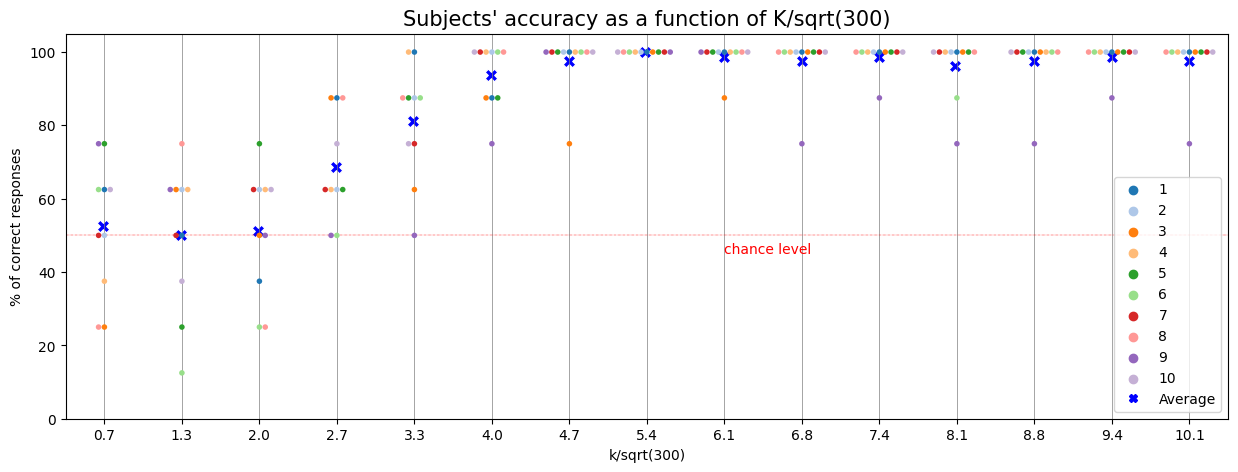

In [ ]:
# CHAT GPT CODE to generate graph:
# Creating graph:
fig, ax = plt.subplots(figsize=(15, 5))
# Set x and y axis limits:
ax.set_xlim(0, 11)
ax.set_ylim(0, 105)
# Swarmplot
swarm_plot = sns.swarmplot(data=swarmplot_df, x='x_label', y='subject_accuracy', palette='tab20', hue='subject_number', size=4, ax=ax)
# Scatterplot
mean_df_grouped = mean_accuracy_df.groupby('x_label').mean().reset_index()
for i, row in mean_df_grouped.iterrows():
    x = row['x_label']
    y = row['subject_accuracy']
    # Get the x-coordinate of the middle of the swarmplot group
    swarm_x = swarm_plot.collections[i].get_offsets()[:, 0].mean()
    # Plot the scatterplot marker at the swarm_x coordinate
    sns.scatterplot(x=[swarm_x], y=[y], color='blue', s=80, marker='X', ax=ax)

# Add vertical lines at each x tick
x_ticks = ax.get_xticks()
for x_tick in x_ticks:
    ax.axvline(x=x_tick, color='gray', linewidth=0.5)

# Move swarmplot legend to bottom-right
handles, labels = swarm_plot.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], bbox_to_anchor=(1, 0), loc='lower right')

# Add custom legend for blue marker
ax.plot([], [], color='blue', marker='X', label="Average", linestyle='None')
ax.legend(loc='lower right')

# Personalizing graph:
plt.axhline(50, color="red", linestyle="dashdot", linewidth=0.3)
plt.annotate('chance level', xy=(8, 45), xytext=(8, 45), color="red", fontsize=10)
ax.set_xlabel('k/sqrt(300)')
ax.set_ylabel('% of correct responses')
plt.title("Subjects' accuracy as a function of K/sqrt(300)", fontsize=15)
# Visualizing graph:
plt.show()


[Text(0.5, 0, 'k/sqrt(300)'), Text(0, 0.5, '% of correct responses')]

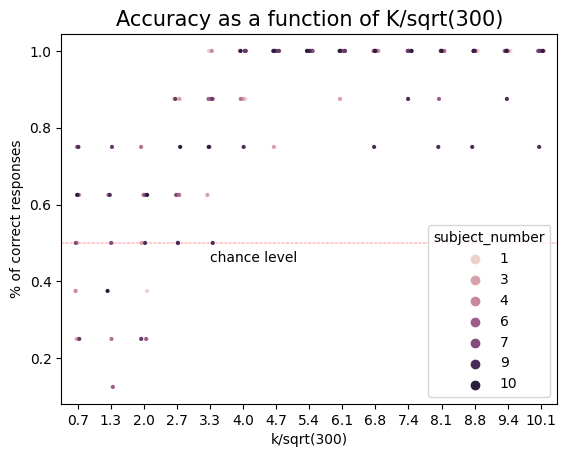

In [ ]:
# STRIPPLOT:
graph=sns.stripplot(data=swarmplot_df,  x="x_label", y="subject_accuracy", hue= "subject_number", size = 3)
graph.axhline(0.5, color = "red", linestyle = "dashdot", linewidth=0.3)
graph.annotate('chance level', xy=(4, 0.45), xytext=(4, 0.45) )
graph.set_title("Accuracy as a function of K/sqrt(300)", fontsize = 15)
graph.set(xlabel='k/sqrt(300)', ylabel="% of correct responses")

---------------------------------------------------------------------

Calculating time needed for each block:

In [ ]:
# importing a single file and calculating average time for each block:
filePath = Path('C:/Users/danie/OneDrive/Desktop/HUPLACLIP-analysis/data_analysis/pilot_1/data/HUPLACLIP_pilot_subj10_2023-04-27_18h19.29.962.csv')
df = pd.read_csv(filePath)
# isolating experiment trials ("canvas-keyboard-response" ones)
df_experiment = df[df.trial_type == "canvas-keyboard-response"]
# dropping empty/irrelevant variables (only "time_elapsed" is used to calculate the time):
df_experiment = df_experiment.drop(["view_history","trial_index","internal_node_id" ,"success", "timeout", "failed_images", "failed_audio", "failed_video", "stimulus", "nodes_order","response","correct_response","graphs_couple","accuracy","presentation_index","clique_size","graph_size"], axis=1)
# for each of the 4 blocks, extracting the first and the last trial and caculating the difference in time:
blocks_duration_list = []
for i in range(4):
    # isolating trials for current block
    df_current_block = df_experiment[df_experiment["block_index"] == i]
    # calculating the difference in time_elapsed between first and last element, transforming it in minutes
    blocks_duration_list.append(( df_current_block.tail(1).time_elapsed.values[0] - df_current_block.head(1).time_elapsed.values[0]) * 1.6667*10**(-5))

# printing the list:
print(blocks_duration_list)
# calculating average of the list:
print(sum(blocks_duration_list) / len(blocks_duration_list))

[2.9914931620000003, 5.167953357, 4.626625864000001, 4.070764747]
4.214209282500001


(TO ADAPT FROM HERE ON)

- Accuracy:

In [ ]:
# 1. overall accuracy ( # correct answers / # final answers )
overall_accuracy = sum(data_experiment.correctnessOfResponse == 1) / sum(~ data_experiment.correctnessOfResponse.isna())
print(overall_accuracy)

# 2. calculating accuracy for the levels of "cliqueSize"
# - obtaining levels of "cliqueSize" (this should match with experiment parameters)
print(data_experiment.cliqueSize.unique())
# - calculating accuracy for the different levels of "cliqueSize"
accuracy_dict = dict()
for i in data_experiment.cliqueSize.unique():
    # isolating data of current clique size:
    current_data = data_experiment[data_experiment.cliqueSize == i]
    accuracy_current_cliqueSize = sum(current_data.correctnessOfResponse == 1) / sum(~ current_data.correctnessOfResponse.isna())
    accuracy_dict[str(round(i))] = accuracy_current_cliqueSize
# plotting the results:
x_values = accuracy_dict.keys()
y_values = accuracy_dict.values()
plt.plot(x_values,y_values)
plt.xlabel("clique size in graph of 300 nodes")
plt.ylabel("accuracy")
plt.tick_params(axis='x', which='major', labelsize=7)

AttributeError: 'DataFrame' object has no attribute 'correctnessOfResponse'

- Number of shuffles:

In [ ]:
# 1. average number of shuffles
# 2. calculating number of shuffles for the levels of "cliqueSize"  (plotting the results)
# note: if number of shuffles increases as a function of "cliqueSize", it could be helping subjects for difficult instances of the task

- Reaction times:

False    391
True       4
Name: rt, dtype: int64


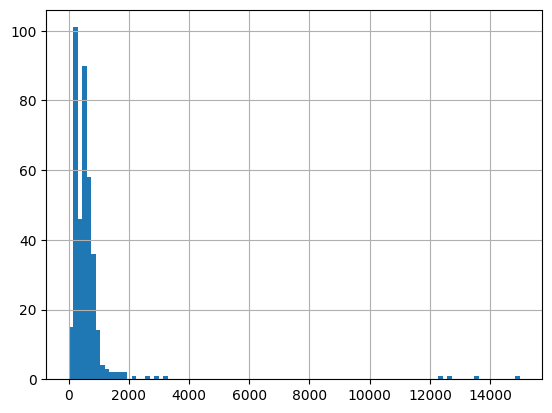

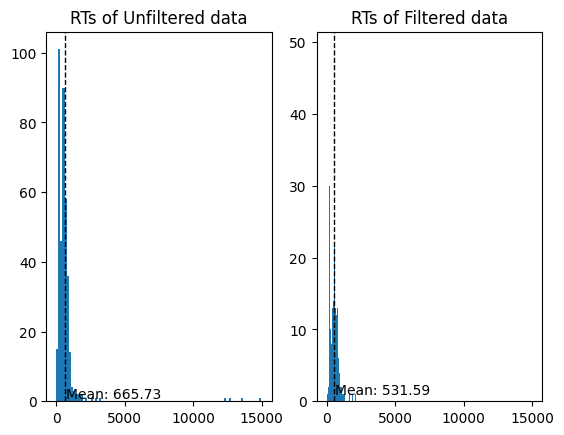

In [ ]:
# 1. average RT (for all trials, both final responses and shuffles)
# 2. RT as a function of "cliqueSize"
# note: if reaction time increases as a function of "cliqueSize", it could be an indication of increasing difficulty

###########################################################


# histogram of reaction times distribution (TO REVIEW):
data.rt.hist(bins=100)
# counting trials that were too slow and removing them (exclusion criterion: rt>7500)
print((data.rt>=7500).value_counts())
data_filtered = data.query('rt < 7500')

#plotting unfiltered and filtered data:
fig, (ax1,ax2) = plt.subplots(1, 2,sharex=True)
min_ylim, max_ylim = plt.ylim()
#unfiltered data
ax1.hist(data.rt,bins=100)
ax1.axvline(data.rt.mean(), color='k', linestyle='dashed', linewidth=1)
ax1.text(data.rt.mean()*1.1,max_ylim*0.9, 'Mean: {:.2f}'.format(data.rt.mean()))
ax1.set_title("RTs of Unfiltered data")
#filtered data
ax2.hist(data_filtered.rt,bins=100)
ax2.axvline(data_filtered.rt.mean(), color='k', linestyle='dashed', linewidth=1)
ax2.text(data_filtered.rt.mean()*1.1,max_ylim*0.9, 'Mean: {:.2f}'.format(data_filtered.rt.mean()))
ax2.set_title("RTs of Filtered data")
plt.show()